In [ ]:
# you only need to run this cell, if data is not present yet
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import os, random

from glob import glob
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import display, Image
from IPython.core.display import HTML

%matplotlib inline


# my imports

from os import listdir
from os.path import isfile, join, abspath
from style_transfer.stylize import transfer



In [3]:
#transfer('dogImages1/test/001.Affenpinscher', 'texture_images', 'output_dir/', num_styles=27 )
transfer(content_dir='dogImages1/test/001.Affenpinscher', style_dir='texture_images', output_dir='dogImages1/test/001.Affenpinscher', num_styles=27 )


  0%|          | 0/216 [00:00<?, ?it/s]

/Users/kmaier/projects/udacity/ml_engineer/capstone_project/cnn-classifier/texture_images
Found 8 content images in /Users/kmaier/projects/udacity/ml_engineer/capstone_project/cnn-classifier/dogImages1/test/001.Affenpinscher
Found 27 style images in /Users/kmaier/projects/udacity/ml_engineer/capstone_project/cnn-classifier/texture_images


100%|██████████| 216/216 [09:45<00:00,  3.60s/it]


---
## Import Data

In [60]:
# Creating paths to training / test data.
train_path = os.path.join('dogImages', 'train')
valid_path = os.path.join('dogImages', 'valid')
test_path = os.path.join('dogImages', 'test')

# Creating paths to pre-processed training / validation / test data.
processed_train_path = os.path.join('dogImages', 'processed_train')
processed_valid_path = os.path.join('dogImages', 'processed_valid')
processed_test_path = os.path.join('dogImages', 'processed_test')

# Make sure these directories exist.
for directory in [ processed_train_path, processed_valid_path, processed_test_path ]:
    if not os.path.isdir(directory):
        os.makedirs(directory)

In [61]:
def subdir_to_paths(directory):
    '''Creates a list of paths for all files across multiple subdirectories.'''
    
    subdirs = sorted(glob('/'.join([directory, '*'])))
    paths = []

    for s in subdirs:
        for filename in os.listdir(s):
            paths.append('/'.join([s, filename]))

    return paths

In [62]:
train_img_paths = subdir_to_paths(train_path)
valid_img_paths = subdir_to_paths(valid_path)
test_img_paths = subdir_to_paths(test_path)

print(train_img_paths[0:5])
print(valid_img_paths[0:5])
print(test_img_paths[0:5])

['dogImages/train/001.Affenpinscher/Affenpinscher_00037.jpg', 'dogImages/train/001.Affenpinscher/Affenpinscher_00022.jpg', 'dogImages/train/001.Affenpinscher/Affenpinscher_00020.jpg', 'dogImages/train/001.Affenpinscher/Affenpinscher_00034.jpg', 'dogImages/train/001.Affenpinscher/Affenpinscher_00008.jpg']
['dogImages/valid/001.Affenpinscher/Affenpinscher_00040.jpg', 'dogImages/valid/001.Affenpinscher/Affenpinscher_00068.jpg', 'dogImages/valid/001.Affenpinscher/Affenpinscher_00041.jpg', 'dogImages/valid/001.Affenpinscher/Affenpinscher_00055.jpg', 'dogImages/valid/001.Affenpinscher/Affenpinscher_00042.jpg']
['dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg', 'dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg', 'dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg', 'dogImages/test/001.Affenpinscher/Affenpinscher_00078.jpg', 'dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg']


In [2]:
#!/usr/bin/env bash
# The VGG-19 network is obtained by:
# 1. converting vgg_normalised.caffemodel to .t7 using loadcaffe
# 2. inserting a convolutional module at the beginning to preprocess the image
# 3. replacing zero-padding with reflection-padding
# The original vgg_normalised.caffemodel can be obtained with:
# "wget -c --no-check-certificate https://bethgelab.org/media/uploads/deeptextures/vgg_normalised.caffemodel"
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=108uza-dsmwvbW2zv-G73jtVcMU_2Nb7Y' -O ./models/vgg_normalised.pth # -P
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1w9r1NoYnn7tql1VYG3qDUzkbIks24RBQ' -O ./models/decoder.pth


--2019-07-30 08:07:24--  https://docs.google.com/uc?export=download&id=108uza-dsmwvbW2zv-G73jtVcMU_2Nb7Y
Resolving docs.google.com (docs.google.com)... 172.217.16.78
Connecting to docs.google.com (docs.google.com)|172.217.16.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-c4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ma73bvt9eoo000udslgivtd3c3uvk39j/1564466400000/06628786844478210003/*/108uza-dsmwvbW2zv-G73jtVcMU_2Nb7Y?e=download [following]
--2019-07-30 08:07:26--  https://doc-08-c4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ma73bvt9eoo000udslgivtd3c3uvk39j/1564466400000/06628786844478210003/*/108uza-dsmwvbW2zv-G73jtVcMU_2Nb7Y?e=download
Resolving doc-08-c4-docs.googleusercontent.com (doc-08-c4-docs.googleusercontent.com)... 216.58.213.193
Connecting to doc-08-c4-docs.googleusercontent.com (doc-08-c4-docs.googleusercontent.com)|216.58.213.193|:443... connected.
HT

In [ ]:
After we downloaded the pretrained models we are now able to execute the actual algorithm to stylize our pictures:

In [52]:
# change directory to our executables
# %cd stylize-datasets
# point the script to our texture_images
# %run -i stylize.py --content-dir 'content_dir/' --style-dir '../texture_images/' --output-dir 'output_dir/' --num-styles 27

# %cd ..

/Users/kmaier/projects/udacity/ml_engineer/capstone_project/cnn-classifier
/Users/kmaier/projects/udacity/ml_engineer/capstone_project/cnn-classifier/stylize-datasets
Found 1 content images in /Users/kmaier/projects/udacity/ml_engineer/capstone_project/cnn-classifier/stylize-datasets/content_dir
Found 27 style images in /Users/kmaier/projects/udacity/ml_engineer/capstone_project/cnn-classifier/texture_images


100%|██████████| 27/27 [01:06<00:00,  2.58s/it]

/Users/kmaier/projects/udacity/ml_engineer/capstone_project/cnn-classifier
/Users/kmaier/projects/udacity/ml_engineer/capstone_project/cnn-classifier


### View Image Samples w/ Class Names

In [80]:
!pwd

/Users/kmaier/projects/udacity/ml_engineer/capstone_project/cnn-classifier


In [84]:
#from stylize-datasets.stylize import main
from style_transfer.skeleton import fib


ModuleNotFoundError: No module named 'style_transfer.skeleton'

In [75]:
output_dir = os.path.join('dogImages1/test/001.Affenpinscher', 'output_dir')
print(os.path.abspath(output_dir))
preprocessed_images = [os.path.join(output_dir, f) for f in listdir(output_dir)]
print(preprocessed_images)

print(train_img_paths)




/Users/kmaier/projects/udacity/ml_engineer/capstone_project/cnn-classifier/stylize-datasets/output_dir
['stylize-datasets/output_dir/English_springer_spaniel_04491-stylized-stairs_1.jpg', 'stylize-datasets/output_dir/English_springer_spaniel_04491-stylized-ground_1.jpg', 'stylize-datasets/output_dir/English_springer_spaniel_04491-stylized-stairs_2.jpg', 'stylize-datasets/output_dir/English_springer_spaniel_04491-stylized-cherries.jpg', 'stylize-datasets/output_dir/English_springer_spaniel_04491-stylized-rgb.jpg', 'stylize-datasets/output_dir/English_springer_spaniel_04491-stylized-blue.jpg', 'stylize-datasets/output_dir/English_springer_spaniel_04491-stylized-wall_4.jpg', 'stylize-datasets/output_dir/English_springer_spaniel_04491-stylized-sand_2.jpg', 'stylize-datasets/output_dir/English_springer_spaniel_04491-stylized-abstract_1.jpg', 'stylize-datasets/output_dir/English_springer_spaniel_04491-stylized-sand_3.jpg', 'stylize-datasets/output_dir/English_springer_spaniel_04491-stylized-

In [67]:
def view_img_samples(img_paths, n_samples):
    '''Displays a random sample of images from a list of image paths.'''
    
    # select random indexes from image path list
    n_images = len(img_paths)
    sample_idxs = np.random.choice(n_images, n_samples, replace=False)

    # display sample images
    fig = plt.figure(figsize=(15,10)) 
    for i in enumerate(sample_idxs):
        # Choose a random file from the training data directory.
        img_path = img_paths[i[1]]
        # Display the image contained in the chosen file.
        img = mpimg.imread(img_path)
        ax = fig.add_subplot(2,3,i[0]+1)
        ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
        plt.title(img_path.split('/')[2])
        plt.axis('off')
    plt.show()    

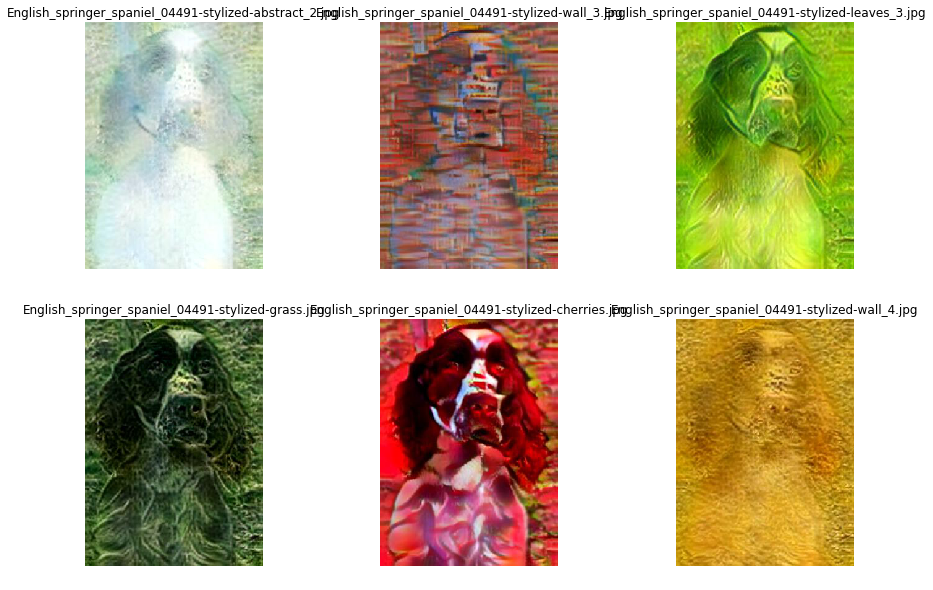

In [76]:
# view style transfered images
view_img_samples(preprocessed_images, 6)

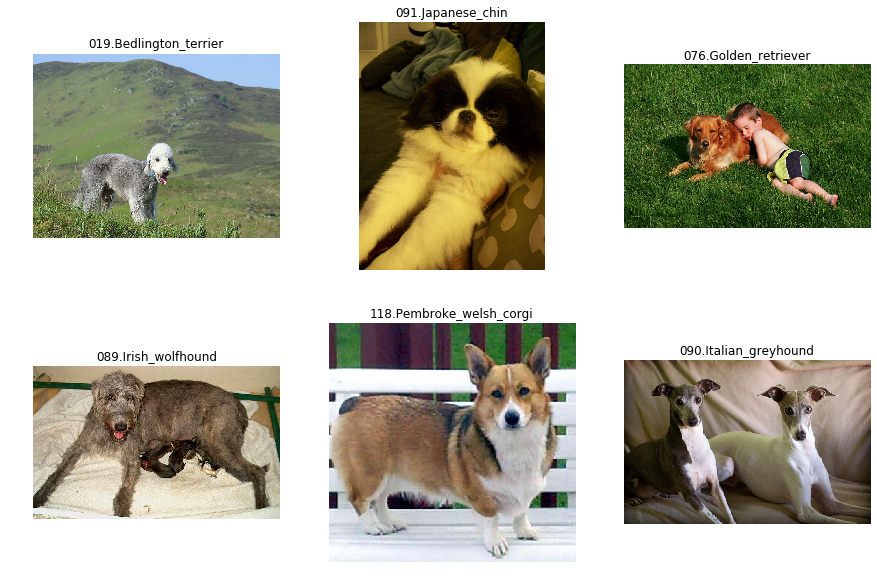

In [6]:
view_img_samples(train_img_paths, 6)

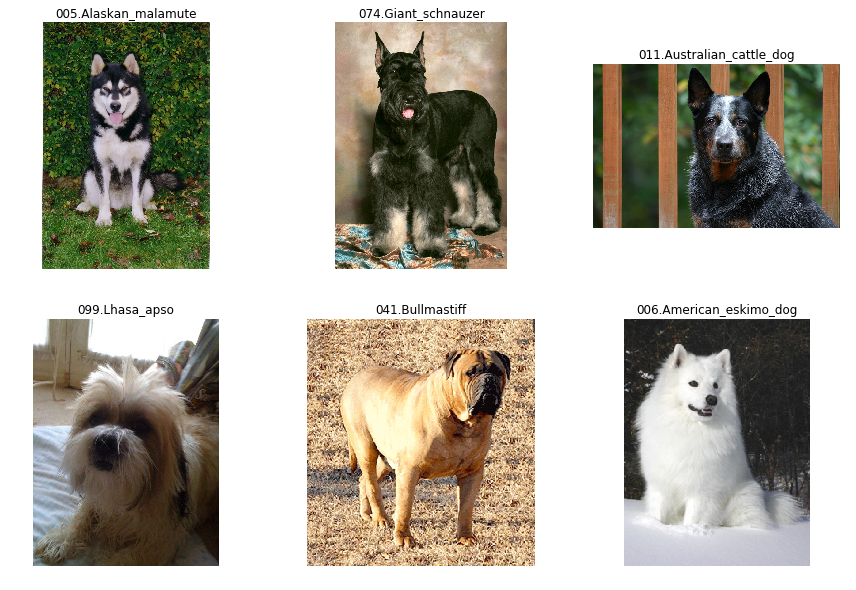

In [7]:
view_img_samples(valid_img_paths, 6)

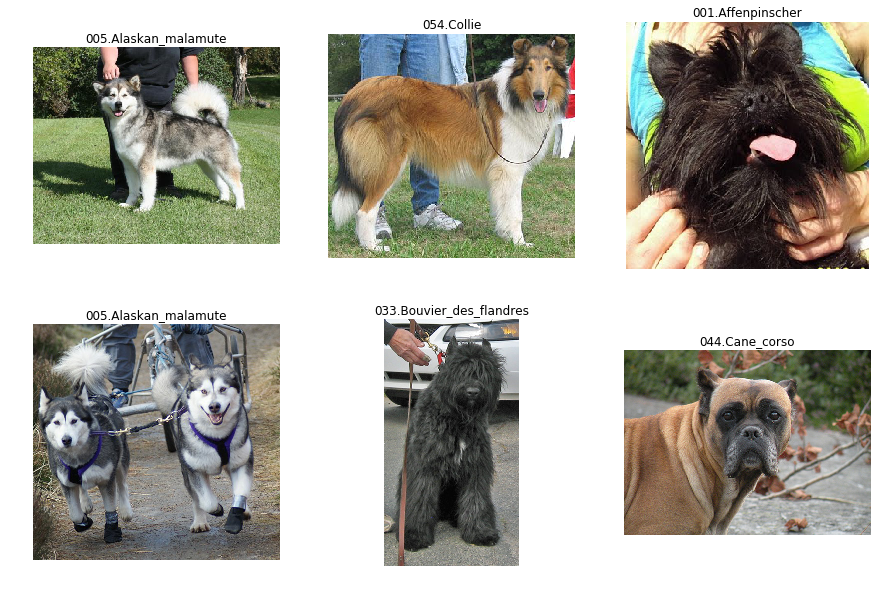

In [8]:
view_img_samples(test_img_paths, 6)

### Further Exploration

In [9]:
# Number of training and test images

n_train = len(train_img_paths)
n_valid = len(valid_img_paths)
n_test = len(test_img_paths)
n_total = n_train + n_valid + n_test

print("No. of training images: {} ({:.0f}%)".format(n_train, (n_train/n_total*100)))
print("No. of validation images: {} ({:.0f}%)".format(n_valid, (n_valid/n_total*100)))
print("No. of testing images: {} ({:.0f}%)".format(n_test, (n_test/n_total*100)))

No. of training images: 6680 (80%)
No. of validation images: 835 (10%)
No. of testing images: 836 (10%)


In [10]:
# Image sizes

widths, heights = [], []
width_min, width_max = np.inf, -np.inf
height_min, height_max = np.inf, -np.inf

for path in train_img_paths:
    image = PIL.Image.open(path)
    
    # Append image dimensions to list.
    widths.append(image.size[0])  # width
    heights.append(image.size[1])  # height

In [11]:
print('(avg width, avg height): ({:.0f}, {:.0f})'.format(np.mean(widths), np.mean(heights)))
print('(min width, max width): ', (np.min(widths), np.max(widths)))
print('(min height, max height): ', (np.min(heights), np.max(heights)))
print('(STD of widths, STD of heights): ({:.0f}, {:.0f})'.format(np.std(widths), np.std(heights)))

(avg width, avg height): (571, 532)
(min width, max width):  (112, 4278)
(min height, max height):  (113, 4003)
(STD of widths, STD of heights): (397, 342)


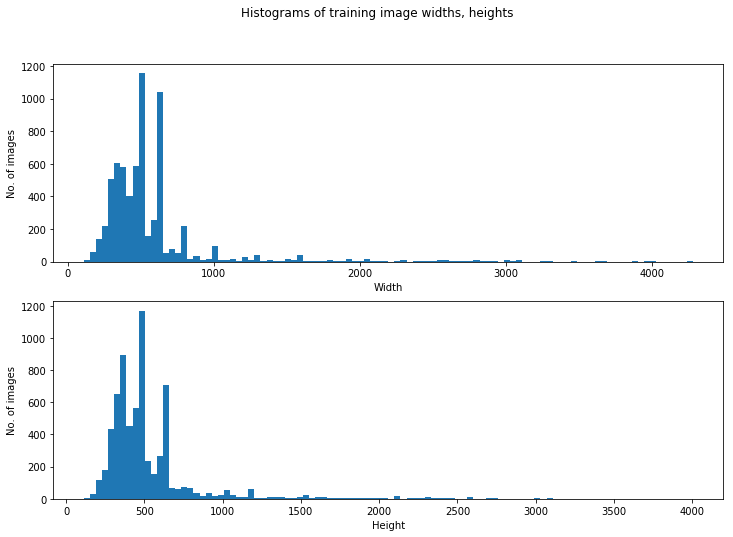

In [12]:
# Plot histograms of heights and widths

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Histograms of training image widths, heights')

ax1.hist(widths, bins=100); ax1.set_xlabel('Width'); ax1.set_ylabel('No. of images')
ax2.hist(heights, bins=100); ax2.set_xlabel('Height'); ax2.set_ylabel('No. of images')

plt.show()